In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import matplotlib.pyplot as plt


from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences


import pandas as pd
from scipy.signal import butter, lfilter
from scipy import stats
from scipy.io import loadmat

#import heartpy as hp

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import seaborn as sns


import math
import random
import zipfile  
import io
from PIL import Image

In [ ]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#IF local runtime used -> Set os.cwd as google drive volume , mounted locally
os.chdir('G:\Il mio Drive')
cwd = os.getcwd()
cwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

In [ ]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
  label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
  peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
  signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
  if os.path.isfile(label_filepath):
    mat_file = loadmat(label_filepath)
    label = np.asarray(mat_file['labels'])
  if os.path.isfile(peak_filepath):
    mat_file = loadmat(peak_filepath)
    peak = np.asarray(mat_file['rpeaks'])
  if os.path.isfile(signal_filepath):
    mat_file = loadmat(signal_filepath)
    signal = np.asarray(mat_file['ecg'] )

  return label, peak, signal

  
labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

print(len(rpeaks))
print(len(rpeaks[0]))

105
2731


In [ ]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols
df

,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S010,"[1.56, 0.92, 0.28, -0.36, -0.29, -0.2, -0.19, ...","[-5.12, -4.485, -3.85, -3.215, -2.58, -1.945, ...","[[96], [169], [268], [360], [427], [539], [634...",128,"[N, V, N, N, V, N, N, V, N, N, V, N, N, V, N, ..."
1,S009,"[0.27, 0.57, 0.36, -0.28, -0.39, -0.32, -0.37,...","[-0.43, -0.93, -1.48, -1.36, -0.82, -0.36, -0....","[[105], [205], [262], [410], [510], [611], [66...",128,"[N, N, V, N, N, N, V, N, N, N, V, N, N, N, V, ..."
2,S008,"[0.405, 0.42, 0.415, 0.43, 0.415, 0.41, 0.445,...","[-0.32, -0.345, -0.325, -0.37, -0.385, -0.42, ...","[[71], [153], [232], [280], [367], [419], [537...",128,"[N, N, N, S, N, S, N, N, S, N, N, S, N, V, N, ..."
3,S007,"[0.145, 0.125, 0.145, 0.145, 0.145, 0.145, 0.1...","[-0.635, -0.745, -0.735, -0.695, -0.685, -0.68...","[[49], [129], [216], [298], [380], [466], [550...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S006,"[0.33, 0.31, 0.32, 0.28, 0.25, 0.22, 0.15, 0.1...","[0.27, 0.24, 0.23, 0.18, 0.16, 0.14, 0.09, 0.0...","[[67], [170], [278], [386], [492], [602], [662...",128,"[N, N, N, N, N, N, V, N, V, N, V, N, V, N, V, ..."
...,...,...,...,...,...,...
100,S110,"[0.065, 0.03, 0.01, 0.01, 0.01, 0.015, 0.035, ...","[0.035, 0.03, 0.025, 0.01, -0.005, -0.01, -0.0...","[[113], [259], [473], [615], [793], [961], [11...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S107,"[0.275, 0.275, 0.275, 0.28, 0.285, 0.305, 0.32...","[0.405, 0.42, 0.435, 0.445, 0.455, 0.465, 0.47...","[[209], [449], [681], [913], [1145], [1373], [...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
102,S108,"[0.105, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1...","[0.115, 0.115, 0.115, 0.115, 0.115, 0.115, 0.1...","[[354], [543], [739], [934], [1129], [1327], [...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S109,"[0.19, 0.195, 0.22, 0.25, 0.25, 0.255, 0.245, ...","[-0.01, -0.015, -0.025, -0.045, -0.04, -0.05, ...","[[55], [269], [497], [729], [963], [1203], [14...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [ ]:
def convert_one_vs_rest(label):
  df = np.zeros(len(label))
  for i in range(len(label)):
    if label[i] == 'S':
      df[i] = 1
    elif label[i] == 'V':
      df[i] = 2
  return df

convert_one_vs_rest(labels[3])

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# dataset needs to be created because we need to classify beats and not the entire signal 

dataset = dict()
length = 510    # length of each signal, centered at the considered peak
counter = 0


for l,id in enumerate(ids):
    print(f"{l}/{len(ids)}",end='\r')
    for i,peak in enumerate(rpeaks[l]):
        
        dataset[id+"_"+str(i)] = {}
        dataset[id+"_"+str(i)]["first_lead"] = list()
        dataset[id+"_"+str(i)]["second_lead"] = list()

        for s in range(int(peak-length/2),int(peak+length/2)):

            if(s < 0 or s >= len(first_lead_signals[l])):   # padding with 0
                dataset[id+"_"+str(i)]["first_lead"].append(0.) 
                dataset[id+"_"+str(i)]["second_lead"].append(0.) 
            else:
                dataset[id+"_"+str(i)]["first_lead"].append(first_lead_signals[l][s])
                dataset[id+"_"+str(i)]["second_lead"].append(first_lead_signals[l][s])

        dataset[id+"_"+str(i)]["stringLabel"] = labels[l][i]
        dataset[id+"_"+str(i)]["label"] = convert_one_vs_rest(labels[l][i])
    
print("complete")

dataset_df = pd.DataFrame.from_dict(dataset,orient="index") # create the dataframe from dictionary 

dataset_df

complete


,first_lead,second_lead,stringLabel,label
S010_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,[0.0]
S010_1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",V,[2.0]
S010_2,"[-0.26, -0.27, -0.19, -0.39, -0.08, -0.39, -0....","[-0.26, -0.27, -0.19, -0.39, -0.08, -0.39, -0....",N,[0.0]
S010_3,"[-0.49, -0.38, -0.35, -0.32, -0.41, -0.23, -0....","[-0.49, -0.38, -0.35, -0.32, -0.41, -0.23, -0....",N,[0.0]
S010_4,"[0.925, 0.285, -0.355, -0.6, -0.5, -0.6, -0.84...","[0.925, 0.285, -0.355, -0.6, -0.5, -0.6, -0.84...",V,[2.0]
...,...,...,...,...
S106_586,"[0.52, 0.485, 0.44, 0.4, 0.36, 0.345, 0.33, 0....","[0.52, 0.485, 0.44, 0.4, 0.36, 0.345, 0.33, 0....",N,[0.0]
S106_587,"[0.43, 0.445, 0.445, 0.435, 0.425, 0.405, 0.38...","[0.43, 0.445, 0.445, 0.435, 0.425, 0.405, 0.38...",N,[0.0]
S106_588,"[0.295, 0.325, 0.355, 0.37, 0.355, 0.335, 0.31...","[0.295, 0.325, 0.355, 0.37, 0.355, 0.335, 0.31...",N,[0.0]
S106_589,"[0.53, 0.535, 0.52, 0.505, 0.475, 0.435, 0.38,...","[0.53, 0.535, 0.52, 0.505, 0.475, 0.435, 0.38,...",N,[0.0]


N: 110848
V: 6107
S: 8045


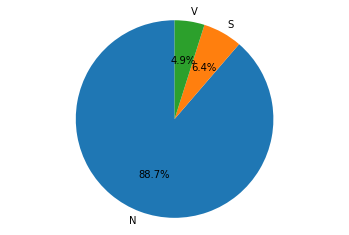

In [ ]:
dataset_df = dataset_df[:125000]

ids_n = dataset_df.index[dataset_df['stringLabel'] == 'N'].tolist() 
ids_v = dataset_df.index[dataset_df['stringLabel'] == 'V'].tolist() 
ids_s = dataset_df.index[dataset_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

N: 110848
V: 6107
S: 8045


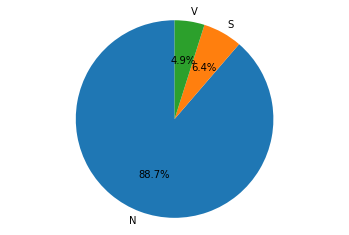

In [ ]:
ids_n = dataset_df.index[dataset_df['label'] == 0].tolist() 
ids_v = dataset_df.index[dataset_df['label'] == 2].tolist() 
ids_s = dataset_df.index[dataset_df['label'] == 1].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

test_percentage = 0.2

train_val_df, test_df = train_test_split(dataset_df, test_size=test_percentage)

In [ ]:
validation_percentage = 0.2

train_df, validation_df = train_test_split(train_val_df, test_size=validation_percentage)

# Training set

x_train_ = train_df[['first_lead','second_lead']].values

x_train_first_lead = list()
x_train_second_lead = list()

for k in x_train_:
  x_train_first_lead.append(np.array(k[0]).astype(np.float32))
  x_train_second_lead.append(np.array(k[1]).astype(np.float32))
x_train_first_lead = np.asarray(x_train_first_lead).astype(np.float32)
x_train_second_lead = np.asarray(x_train_second_lead).astype(np.float32)

x_train = np.zeros((x_train_first_lead.shape[0], x_train_first_lead.shape[1], 2))
x_train[:,:,0] = x_train_first_lead
x_train[:,:,1] = x_train_second_lead

y_train = train_df['label'].values.tolist()
y_train = np.asarray(y_train).astype(np.float32)
y_train[y_train==2] = 1


# Validation set

x_valid_ = validation_df[['first_lead','second_lead']].values

x_valid_first_lead = list()
x_valid_second_lead = list()

for k in x_valid_:
  x_valid_first_lead.append(np.array(k[0]).astype(np.float32))
  x_valid_second_lead.append(np.array(k[1]).astype(np.float32))
x_valid_first_lead = np.asarray(x_valid_first_lead).astype(np.float32)
x_valid_second_lead = np.asarray(x_valid_second_lead).astype(np.float32)

x_valid = np.zeros((x_valid_first_lead.shape[0], x_valid_first_lead.shape[1], 2))
x_valid[:,:,0] = x_valid_first_lead
x_valid[:,:,1] = x_valid_second_lead

y_valid = validation_df['label'].values.tolist()
y_valid = np.asarray(y_valid).astype(np.float32)
y_valid[y_valid==2] = 1

print(f"samples available for training: {len(x_train)}")
print(f"samples available for validation: {len(x_valid)}")

samples available for training: 156374
samples available for validation: 39094


N: 71018
V: 8982


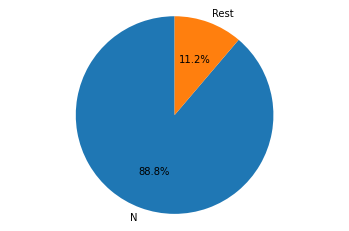

In [ ]:
# count classes for training

ids_n = train_df.index[train_df['stringLabel'] == 'N'].tolist() 
ids_rest = train_df.index[train_df['stringLabel'] != 'N'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_rest)}")

classes = ["N","Rest"]
counts = [len(ids_n),len(ids_rest)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

N: 36350
V: 2744


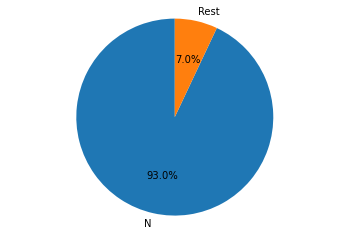

In [ ]:
# count classes for validation

ids_n = validation_df.index[validation_df['stringLabel'] == 'N'].tolist() 
ids_rest = validation_df.index[validation_df['stringLabel'] != 'N'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_rest)}")

classes = ["N","Rest"]
counts = [len(ids_n),len(ids_rest)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  con_mat = tf.math.confusion_matrix(labels=np.squeeze(y_true), predictions=np.rint(np.squeeze(y_pred))).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# Models

### N vs Rest

In [ ]:
timesteps = length
channels_num = 2

input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(1, activation=tf.nn.sigmoid)(lstm2)
model = keras.models.Model(inputs=input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 510, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 486, 32)           1632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 243, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 243, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 232, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 116, 64)          0         
 1D)                                                         

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)

batch_size = 128
learning_rate = 1e-7
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    
)

history = model.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 50,
    shuffle = True,
    callbacks=[callback],
).history


y_pred = model.predict(x_valid)

plot_confusion_matrix(y_valid, y_pred)

Epoch 1/50
1221/1221 [==============================] - 27s 21ms/step - loss: 0.0226 - accuracy: 0.9915 - val_loss: 0.0310 - val_accuracy: 0.9903
Epoch 2/50
1221/1221 [==============================] - 24s 20ms/step - loss: 0.0216 - accuracy: 0.9919 - val_loss: 0.0316 - val_accuracy: 0.9900
Epoch 3/50
1221/1221 [==============================] - 24s 20ms/step - loss: 0.0210 - accuracy: 0.9921 - val_loss: 0.0299 - val_accuracy: 0.9900
Epoch 4/50
1221/1221 [==============================] - 24s 20ms/step - loss: 0.0202 - accuracy: 0.9924 - val_loss: 0.0310 - val_accuracy: 0.9903
Epoch 5/50
1221/1221 [==============================] - 24s 20ms/step - loss: 0.0208 - accuracy: 0.9921 - val_loss: 0.0309 - val_accuracy: 0.9897
Epoch 6/50
1221/1221 [==============================] - 25s 20ms/step - loss: 0.0205 - accuracy: 0.9922 - val_loss: 0.0323 - val_accuracy: 0.9902
Epoch 7/50
1221/1221 [==============================] - 24s 20ms/step - loss: 0.0196 - accuracy: 0.9928 - val_loss: 0.0301 -

NameError: ignored

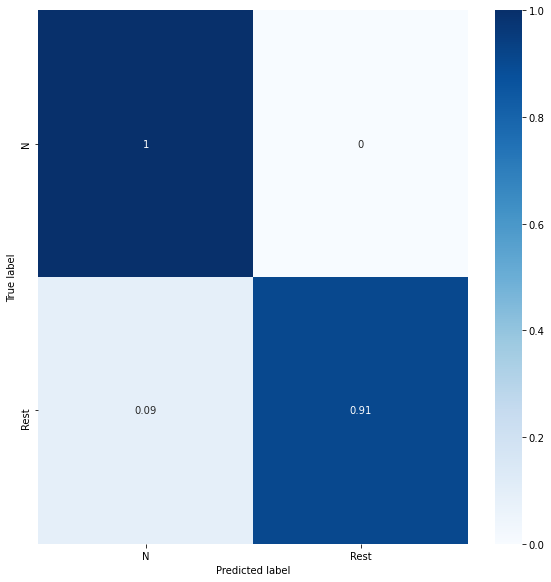

In [ ]:
y_pred = model.predict(x_valid)

plot_confusion_matrix(y_valid, y_pred)

In [ ]:
tf.math.confusion_matrix(labels=np.squeeze(y_valid), predictions=np.rint(np.squeeze(y_pred))).numpy()

array([[17617,   112],
       [  203,  2068]], dtype=int32)

In [ ]:
eval = model.evaluate(x=x_valid,y=y_valid,batch_size = 1)

39094/39094 [==============================] - 266s 7ms/step - loss: 0.0299 - accuracy: 0.9900


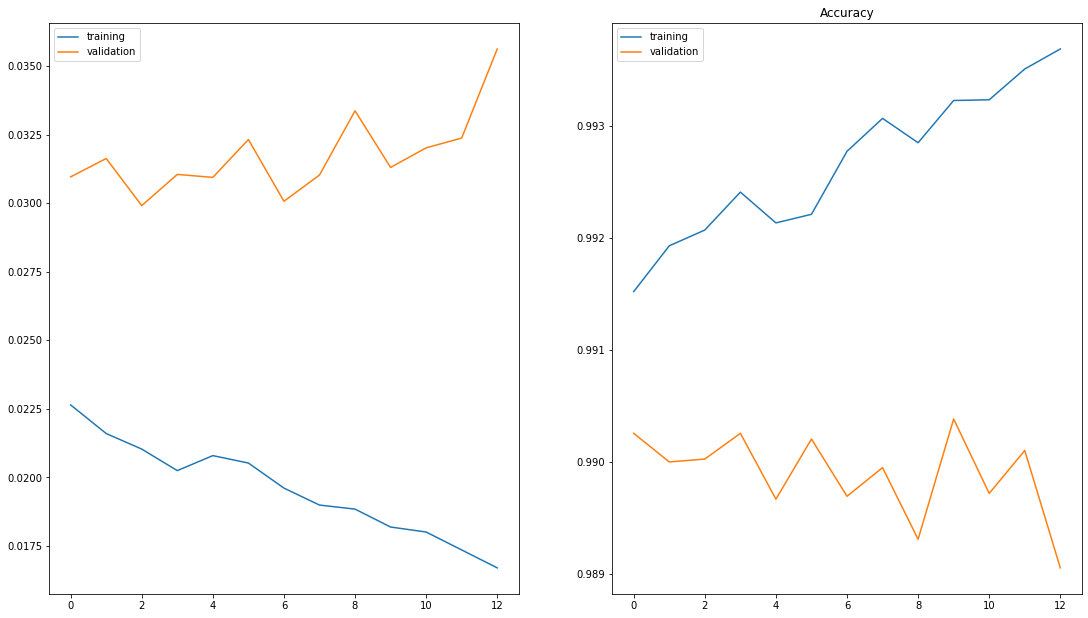

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2)

x = range(len(history['loss']))
# loss
y_train = history['loss']
y_valid = history['val_loss']
ax2.set_title("Loss")
ax1.plot(x,y_train,label="training")
ax1.plot(x,y_valid,label="validation")
ax1.legend()
# accuracy 
y_train = history['accuracy']
y_valid = history['val_accuracy']
ax2.set_title("Accuracy")
ax2.plot(x,y_train,label="training")
ax2.plot(x,y_valid,label="validation")
ax2.legend()

fig.set_size_inches(18.5, 10.5)
plt.show()

### S vs V (discarding N)

In [ ]:
x_ = train_val_df[['first_lead','second_lead']].values

x_first_lead = list()
x_second_lead = list()

for k in x_:
  x_first_lead.append(np.array(k[0]).astype(np.float32))
  x_second_lead.append(np.array(k[1]).astype(np.float32))
x_first_lead = np.asarray(x_first_lead).astype(np.float32)
x_second_lead = np.asarray(x_second_lead).astype(np.float32)

x = np.zeros((x_first_lead.shape[0], x_first_lead.shape[1], 2))
x[:,:,0] = x_first_lead
x[:,:,1] = x_second_lead

y = train_val_df['label'].values.tolist()
y = np.asarray(y).astype(np.int)

In [ ]:
np.histogram(y)

(array([88747,     0,     0,     0,     0,  6391,     0,     0,     0,
         4862]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]))

In [ ]:
# eval = model.evaluate(x=x,y=y,batch_size = 1)

In [ ]:
y_red = y[y!=0] # Remove 'N' and consider the rest

len(y_red)

13933

In [ ]:
np.histogram(y)

(array([88747,     0,     0,     0,     0,  6391,     0,     0,     0,
         4862]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]))

In [ ]:
x_red = x[np.squeeze(y)!=0]
x_red.shape

(13933, 510, 2)

In [ ]:
validation_percentage = 0.2

x_red_train, x_red_valid, y_red_train, y_red_valid = train_test_split(x_red, y_red, test_size=validation_percentage)

print(f"samples available for training: {len(x_red_train)}")
print(f"samples available for validation: {len(x_red_valid)}")

samples available for training: 11146
samples available for validation: 2787


S: 6209
V: 4937


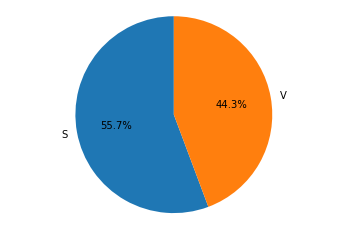

In [ ]:
# count classes for training

ids_s = x_red_train[y_red_train == 1].tolist() 
ids_v = x_red_train[y_red_train == 2].tolist() 

print(f"S: {len(ids_s)}")
print(f"V: {len(ids_v)}")

classes = ["S","V"]
counts = [len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

S: 6209
V: 4937


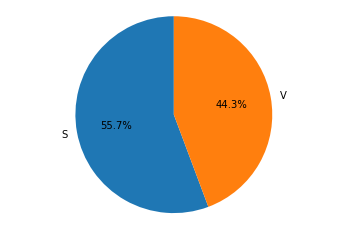

In [ ]:
# count classes for validation

ids_s = x_red_train[y_red_train == 1].tolist() 
ids_v = x_red_train[y_red_train == 2].tolist() 

print(f"S: {len(ids_s)}")
print(f"V: {len(ids_v)}")

classes = ["S","V"]
counts = [len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [ ]:
y_red_train[y_red_train==2] = 3
y_red_valid[y_red_valid==2] = 3

y_red_train[y_red_train==1] = 0
y_red_valid[y_red_valid==1] = 0
y_red_train[y_red_train==3] = 1
y_red_valid[y_red_valid==3] = 1

In [ ]:
np.histogram(y_red_train)

(array([5109,    0,    0,    0,    0,    0,    0,    0,    0, 3893]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
timesteps = length
channels_num = 2

input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(1, activation=tf.nn.sigmoid)(lstm2)
model_red = keras.models.Model(inputs=input, outputs=output)

model_red.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 510, 2)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 486, 32)           1632      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 243, 32)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 243, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 232, 64)           24640     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 116, 64)          0         
 1D)                                                       

Epoch 1/100
87/87 [==============================] - 19s 175ms/step - loss: 0.1923 - accuracy: 0.9325 - val_loss: 0.1852 - val_accuracy: 0.9257
Epoch 2/100
87/87 [==============================] - 14s 167ms/step - loss: 0.1655 - accuracy: 0.9411 - val_loss: 0.1648 - val_accuracy: 0.9455
Epoch 3/100
87/87 [==============================] - 14s 167ms/step - loss: 0.1582 - accuracy: 0.9465 - val_loss: 0.1533 - val_accuracy: 0.9447
Epoch 4/100
87/87 [==============================] - 14s 167ms/step - loss: 0.1403 - accuracy: 0.9507 - val_loss: 0.1478 - val_accuracy: 0.9537
Epoch 5/100
87/87 [==============================] - 14s 166ms/step - loss: 0.1293 - accuracy: 0.9553 - val_loss: 0.1294 - val_accuracy: 0.9569
Epoch 6/100
87/87 [==============================] - 14s 168ms/step - loss: 0.1170 - accuracy: 0.9585 - val_loss: 0.1285 - val_accuracy: 0.9534
Epoch 7/100
87/87 [==============================] - 15s 168ms/step - loss: 0.1079 - accuracy: 0.9608 - val_loss: 0.1215 - val_accuracy:

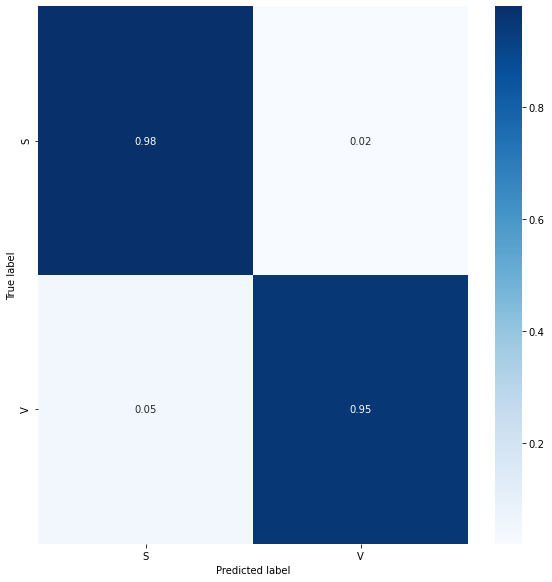

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)

batch_size = 128
learning_rate = 1e-12
model_red.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    
)

history2 = model_red.fit(
    x = x_red_train,
    y = y_red_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_red_train)/batch_size,
    validation_data=(x_red_valid, y_red_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
).history


y_red_pred = model_red.predict(x_red_valid)

plot_confusion_matrix(y_red_valid, y_red_pred)

In [ ]:
tf.math.confusion_matrix(labels=np.squeeze(y_red_valid), predictions=np.rint(np.squeeze(y_red_pred))).numpy()

array([[1256,   26],
       [  42,  927]], dtype=int32)

In [ ]:
eval = model_red.evaluate(x=x_red_valid,y=y_red_valid,batch_size = 1)

2787/2787 [==============================] - 30s 6ms/step - loss: 0.1057 - accuracy: 0.9645


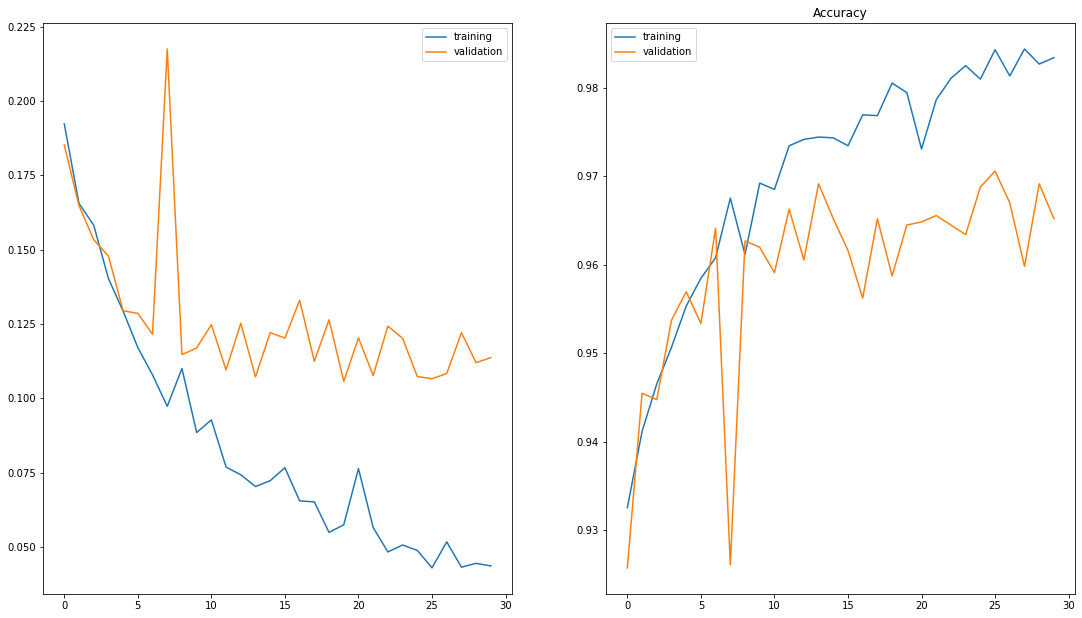

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2)

x = range(len(history2['loss']))
# loss
y_train = history2['loss']
y_valid = history2['val_loss']
ax2.set_title("Loss")
ax1.plot(x,y_train,label="training")
ax1.plot(x,y_valid,label="validation")
ax1.legend()
# accuracy 
y_train = history2['accuracy']
y_valid = history2['val_accuracy']
ax2.set_title("Accuracy")
ax2.plot(x,y_train,label="training")
ax2.plot(x,y_valid,label="validation")
ax2.legend()

fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
# Test set

x_test_ = test_df[['first_lead','second_lead']].values

x_test_first_lead = list()
x_test_second_lead = list()

for k in x_test_:
  x_test_first_lead.append(np.array(k[0]).astype(np.float32))
  x_test_second_lead.append(np.array(k[1]).astype(np.float32))
x_test_first_lead = np.asarray(x_test_first_lead).astype(np.float32)
x_test_second_lead = np.asarray(x_test_second_lead).astype(np.float32)

x_test = np.zeros((x_test_first_lead.shape[0], x_test_first_lead.shape[1], 2))
x_test[:,:,0] = x_test_first_lead
x_test[:,:,1] = x_test_second_lead

y_test = test_df['label'].values.tolist()
y_test = np.asarray(y_test).astype(np.float32)

In [ ]:
x_test.shape

(25000, 510, 2)

In [ ]:
y_test.shape

(25000, 1)

In [ ]:
y_test_1 = y_test.copy()
y_test_1[y_test_1==2] = 1

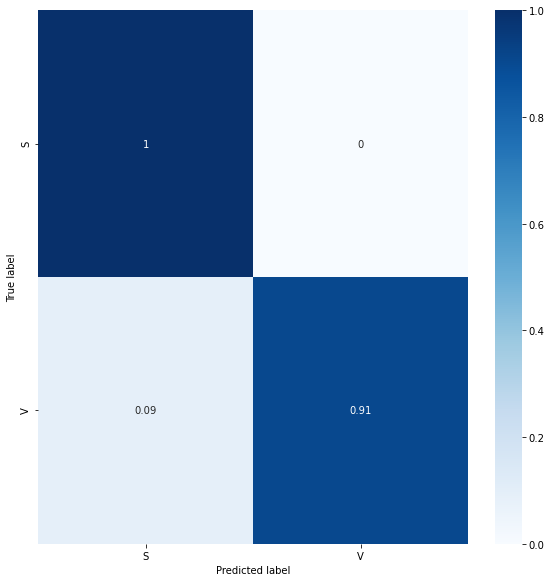

In [ ]:
y_test_pred_1 = model.predict(x_test)

plot_confusion_matrix(y_test_1, y_test_pred_1)

In [ ]:
tf.math.confusion_matrix(labels=np.squeeze(y_test_1), predictions=np.rint(np.squeeze(y_test_pred_1))).numpy()

array([[21976,   125],
       [  274,  2625]], dtype=int32)

In [ ]:
eval_model1 = model.evaluate(x=x_test,y=y_test_1,batch_size = 1)

48868/48868 [==============================] - 329s 6ms/step - loss: 0.0301 - accuracy: 0.9898


In [ ]:
y_test_pred_1 = np.rint(np.squeeze(y_test_pred_1))

In [ ]:
x_test_2 = x_test[y_test_pred_1!=0]
y_test_2 = y_test[y_test_pred_1!=0]

In [ ]:
x_test_2.shape

(2750, 510, 2)

In [ ]:
y_test_2.shape

(2750, 1)

In [ ]:
y_test_2[y_test_2==2] = 3

y_test_2[y_test_2==1] = 0
y_test_2[y_test_2==3] = 1

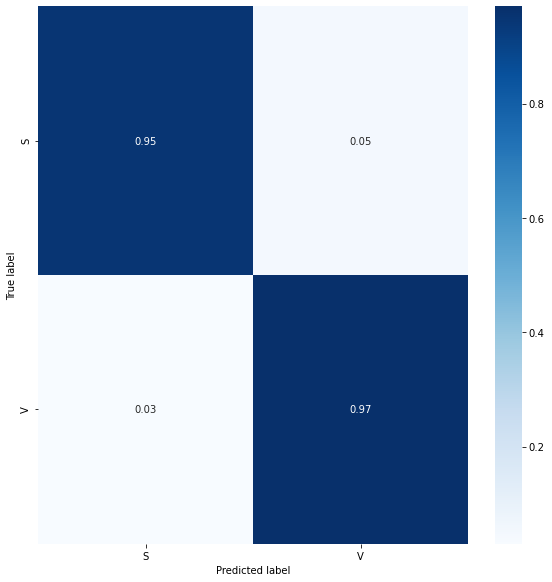

In [ ]:
y_test_pred_2 = model_red.predict(x_test_2)

plot_confusion_matrix(y_test_2, y_test_pred_2)

In [ ]:
tf.math.confusion_matrix(labels=np.squeeze(y_test_2), predictions=np.rint(np.squeeze(y_test_pred_2))).numpy()

array([[1697,   82],
       [  52, 1508]])

In [ ]:
eval_model2 = model_red.evaluate(x=x_test_2,y=y_test_2,batch_size = 1)

2295/3339 [===================>..........] - ETA: 5s - loss: 0.1300 - accuracy: 0.9608